## Heart Rate Monitoring During Physical Exercise Using Wrist-Type Photoplethysmographic (PPG) Signals with Fedot.Industrial

The goal of this dataset is to estimate heart rate using PPG sensors. This dataset contains 3096, 5 dimensional time series obtained from the IEEE Signal Processing Cup 2015: Heart Rate Monitoring During Physical Exercise Using Wrist-Type Photoplethysmographic (PPG) Signals. Two-channel PPG signals, three-axis acceleration signals, and one-channel ECG signals were simultaneously recorded from subjects with age from 18 to 35. For each subject, the PPG signals were recorded from wrist by two pulse oximeters with green LEDs (wavelength: 515nm). Their distance (from center to center) was 2 cm. The acceleration signal was also recorded from wrist by a three-axis accelerometer. Both the pulse oximeter and the accelerometer were embedded in a wristband, which was comfortably worn. The ECG signal was recorded simultaneously from the chest using wet ECG sensors. All signals were sampled at 125 Hz and sent to a nearby computer via Bluetooth.
Link to the dataset - https://zenodo.org/record/3902710

In [1]:
import sys
import os

project_path = r"add_project_path_here\Fedot.Industrial"
sys.path.append(project_path)

In [2]:
import pandas as pd
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.tools.loader import DataLoader
from fedot_ind.api.main import FedotIndustrial
from fedot_ind.core.architecture.pipelines.abstract_pipeline import ApiTemplate

The list of basic fedot industrial models for experiment are shown below. We are using simple linear machine learning pipelines with 3 different feature generators: Statistical, Recurrence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [3]:
from fedot_ind.core.repository.config_repository import DEFAULT_COMPUTE_CONFIG, DEFAULT_REG_AUTOML_CONFIG, DEFAULT_AUTOML_LEARNING_CONFIG

initial_assumption = {0: 'quantile_extractor', 1: 'treg'}

API_CONFIG = {'industrial_config': {'problem': 'regression'},
              'automl_config': DEFAULT_REG_AUTOML_CONFIG,
              'learning_config': {'learning_strategy': 'from_scratch',
                                  'learning_strategy_params': DEFAULT_AUTOML_LEARNING_CONFIG,
                                  'optimisation_loss': {'quality_loss': 'rmse'}},
              'compute_config': DEFAULT_COMPUTE_CONFIG}
METRIC_NAMES = ('r2', 'rmse', 'mae')
DATASET_NAME = 'IEEEPPG'

In [4]:
api_client = ApiTemplate(api_config=API_CONFIG,
                         metric_list=METRIC_NAMES)

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [28]:
initial_assumption_finetune = {0: ['quantile_extractor', 'treg']}
result_dict_finetune = api_client.eval(dataset=DATASET_NAME, finetune=True, initial_assumption=initial_assumption_finetune)

2025-01-25 19:17:12,036 - OptunaTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [treg, quantile_extractor]}
treg - {}
quantile_extractor - {} 
Initial metric: [14.984]


[I 2025-01-25 19:17:12,038] A new study created in memory with name: no-name-86386cc1-7916-4350-bc95-f41cd7632efc


Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.00714 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.01185 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.00623 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.00626 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.01081 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.01568 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.00574 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.00988 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.00791 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.01039 sec
Features of basis of <class 'numpy.ndarray'> type are loaded from cache in 0.0309 sec
Features of basis of <class 'numpy.ndarray'>

In [29]:
labels = result_dict_finetune['labels']
metrics = result_dict_finetune['metrics']

In [30]:
metrics

,r2,rmse,mae
0,0.166,28.384,23.711


## AutoML approach

In [5]:
result_dict = api_client.eval(dataset=DATASET_NAME, finetune=False, initial_assumption=initial_assumption)

2025-01-25 02:40:58,705 - Reading data from C:\Users\Bars\PycharmProjects\Fedot.Industrial\fedot_ind\data\IEEEPPG
2025-01-25 02:41:09,972 - Data read successfully from local folder
2025-01-25 02:41:10,620 - --------------------------------------------------
2025-01-25 02:41:10,622 - Initialising Industrial Repository
2025-01-25 02:41:10,623 - -------------------------------------------------
2025-01-25 02:41:10,624 - Initialising Industrial Evolutionary Optimisation params
2025-01-25 02:41:10,733 - --------------------------------------------------
2025-01-25 02:41:10,735 - Initialising Dask Server
Creating Dask Server
2025-01-25 02:41:12,191 - State start
2025-01-25 02:41:12,202 - Found stale lock file and directory 'C:\\Users\\Bars\\AppData\\Local\\Temp\\dask-scratch-space\\scheduler-tt2l8fts', purging
2025-01-25 02:41:12,206 - Found stale lock file and directory 'C:\\Users\\Bars\\AppData\\Local\\Temp\\dask-scratch-space\\worker-bx2b_l9v', purging
2025-01-25 02:41:12,241 -   Schedule

In [10]:
import numpy as np
features = np.array(api_client.train_data[0].tolist()).astype(float)

Lets check our data.

In [11]:
features.shape

(1768, 5, 1000)

Lets visualise our predictors.

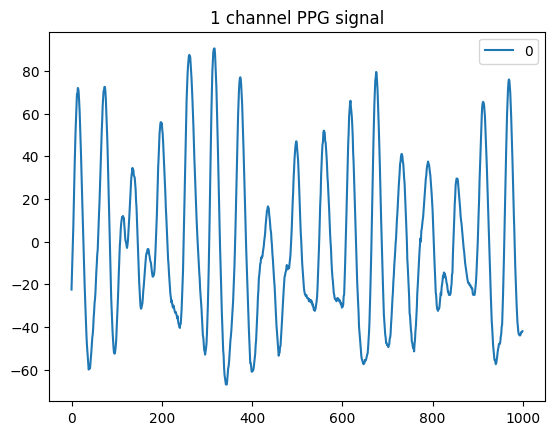

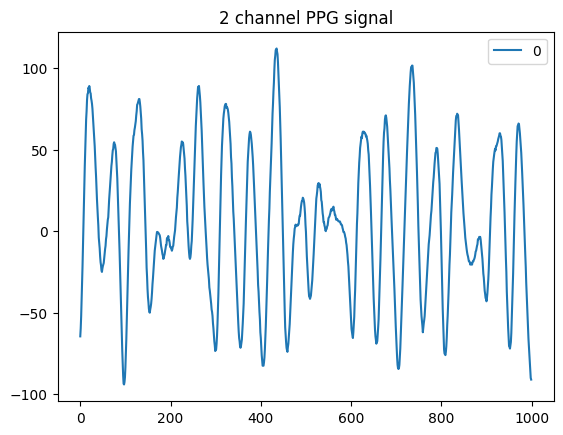

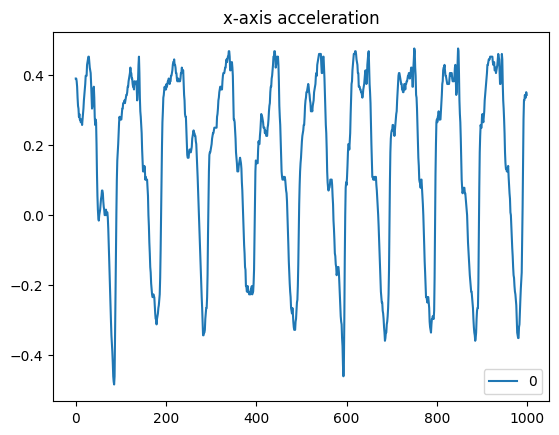

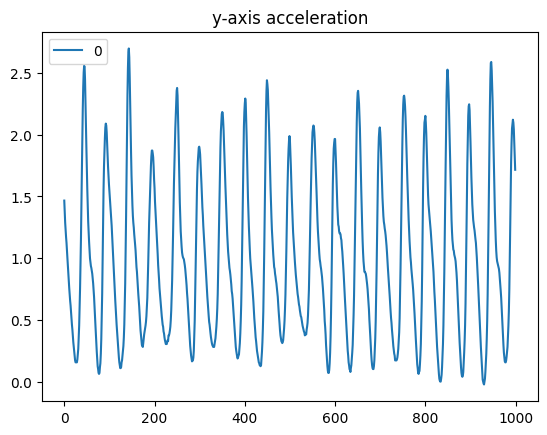

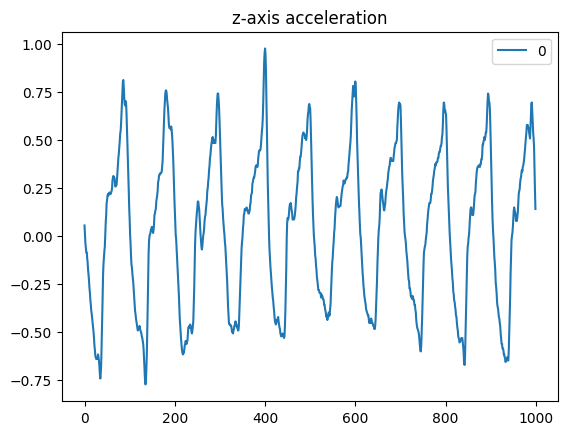

In [12]:
from matplotlib import pyplot as plt
pd.DataFrame(features[1, 0, :]).plot(title='1 channel PPG signal')
pd.DataFrame(features[1, 1, :]).plot(title='2 channel PPG signal')
pd.DataFrame(features[1, 2, :]).plot(title='x-axis acceleration')
pd.DataFrame(features[1, 3, :]).plot(title='y-axis acceleration')
pd.DataFrame(features[1, 4, :]).plot(title='z-axis acceleration')
plt.show()

In [17]:
auto_labels = result_dict['labels']
auto_metrics = result_dict['metrics']

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [18]:
auto_metrics

,r2,rmse,mae
0,-0.387,36.614,29.311


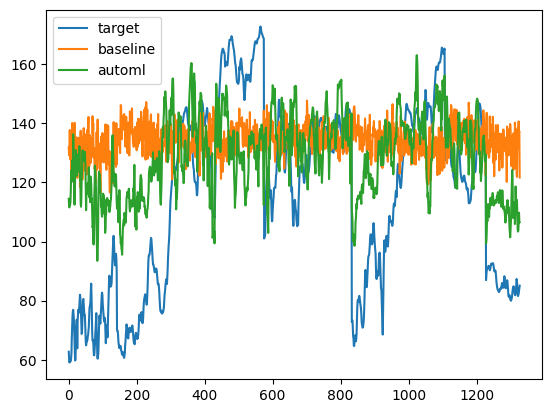

In [31]:
predictions = np.vstack([api_client.test_data[1].flatten(), labels.flatten(), auto_labels.flatten()]).T
all_prediction = pd.DataFrame(predictions, columns=['target', 'baseline', 'automl'])
all_prediction.plot()
plt.show()

In [21]:
import numpy as np
features = np.array(api_client.test_data[0].tolist()).astype(float)

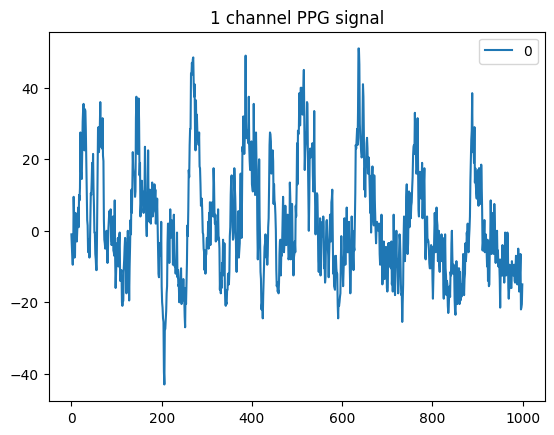

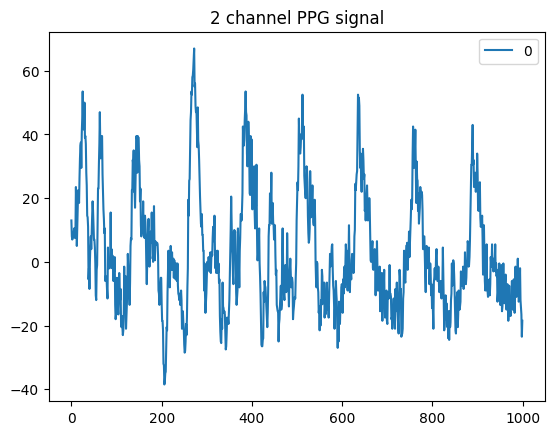

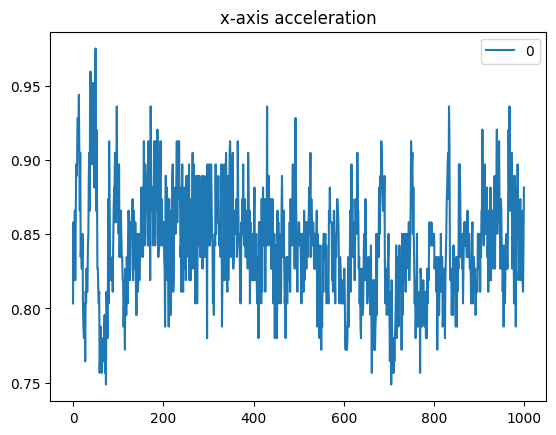

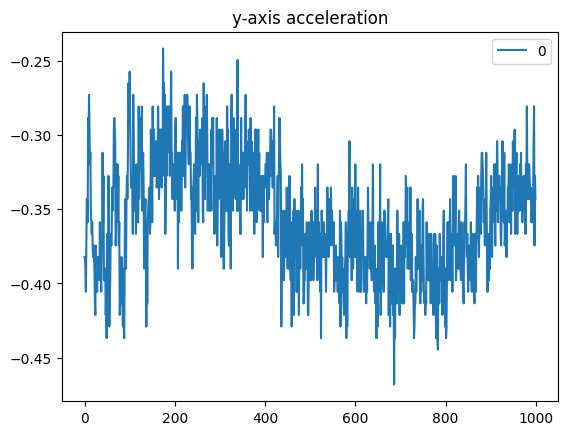

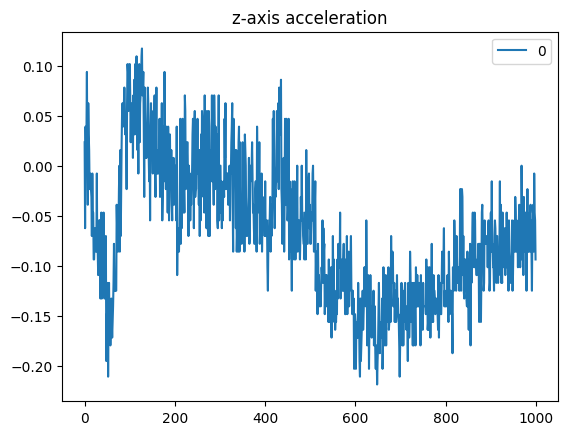

In [22]:
pd.DataFrame(features[1, 0, :]).plot(title='1 channel PPG signal')
pd.DataFrame(features[1, 1, :]).plot(title='2 channel PPG signal')
pd.DataFrame(features[1, 2, :]).plot(title='x-axis acceleration')
pd.DataFrame(features[1, 3, :]).plot(title='y-axis acceleration')
pd.DataFrame(features[1, 4, :]).plot(title='z-axis acceleration')
plt.show()

## Compare with State of Art (SOTA) models

In [15]:
data_path = project_path + '\examples\data'
df = pd.read_csv(data_path+'\ts_regression_sota_results.csv',sep=';')

In [16]:
df = df[df['ds/type'] == DATASET_NAME].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)

In [17]:
df['Fedot_Industrial_tuned'] = metrics['rmse'][0]
df['Fedot_Industrial_AutoML'] = auto_metrics['rmse'][0]
df = df.T

In [18]:
df.sort_values('min')

algorithm,min,max,average
InceptionT_RMSE,2.326973,23.144061,3.698176
SingleInception_RMSE,2.862294,24.226917,4.119866
ResNet_RMSE,3.517166,33.038647,5.051279
FCN_RMSE,4.934538,36.772476,7.190419
ROCKET_RMSE,6.016981,27.583495,7.159721
RIST_RMSE,6.967740,27.277590,11.477876
MultiROCKET_RMSE,7.536678,29.900533,8.771684
RDST_RMSE,8.051669,25.700414,11.626389
FreshPRINCE_RMSE,8.489912,33.689079,10.115907
DrCIF_RMSE,11.201905,34.916949,12.474585


In [19]:
df.sort_values('max')

algorithm,min,max,average
RotF_RMSE,19.284382,20.824608,20.212812
InceptionT_RMSE,2.326973,23.144061,3.698176
SingleInception_RMSE,2.862294,24.226917,4.119866
RDST_RMSE,8.051669,25.700414,11.626389
5NN-ED_RMSE,22.438166,27.111213,23.655007
RIST_RMSE,6.967740,27.277590,11.477876
ROCKET_RMSE,6.016981,27.583495,7.159721
Fedot_Industrial_tuned,29.674000,29.674000,29.674000
Fedot_Industrial_AutoML,29.869000,29.869000,29.869000
MultiROCKET_RMSE,7.536678,29.900533,8.771684


In [20]:
df.sort_values('average')

algorithm,min,max,average
InceptionT_RMSE,2.326973,23.144061,3.698176
SingleInception_RMSE,2.862294,24.226917,4.119866
ResNet_RMSE,3.517166,33.038647,5.051279
ROCKET_RMSE,6.016981,27.583495,7.159721
FCN_RMSE,4.934538,36.772476,7.190419
MultiROCKET_RMSE,7.536678,29.900533,8.771684
FreshPRINCE_RMSE,8.489912,33.689079,10.115907
RIST_RMSE,6.967740,27.277590,11.477876
RDST_RMSE,8.051669,25.700414,11.626389
DrCIF_RMSE,11.201905,34.916949,12.474585
